# Fractals and Dimension 2: Elementary CA

Continuing our exploration of fractal dimension.
How to estimate the fractal dimension of the pattern rendered by a Cellular Automata?

As usual, the first code block just imports the modules we will use.

In [23]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Elementary CA
Here is the code we developed for exploring elementary CA...

In [24]:
POWERS_OF_2 = np.array((4, 2, 1))

def rule_indexes(state):
    """ Return vector of rule indexes - one index for each 3-cell neighbourhood in the CA state vector. """
    # numpy's version of the "sliding dot product" algorithm:
    return np.correlate(state, POWERS_OF_2, mode='same')

assert all( rule_indexes(np.array([1,1,0,0,1,0,0,0])) == [3, 6, 4, 1, 2, 4, 0, 0] )


def transition(state, rule_lookup_table):
    """ Return a np.array for the state transition for given CA state under the given 8-bit rule """
    return np.array([rule_lookup_table[i] for i in rule_indexes(state)])

rule_110 = (0,1,1,0,1,1,1,0)[::-1]
assert all( transition(np.array((0,0,1,1,1,0,0,0,1,1,0)), rule_110) == (0,1,1,0,1,0,0,1,1,1,0))


# This algorithm is from the textbook - it uses numpy to do a decimal to binary conversion.
def get_lookup_table(rule):
    """
    Return the 8-bit transition vector for the given elementary CA rule number.
    rule: int 0-255
    returns: transition lookup table - a 8 element vector of 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    return np.unpackbits(rule)[::-1]

assert np.all( get_lookup_table(110) == rule_110 )


def single_centre_array(n_cells):
    """ Return a binary 1D array with given number of cells, all zeros except a single 1 in the centre cell """
    array = np.zeros(n_cells, dtype=np.uint8)
    array[n_cells//2] = 1
    return array

assert np.all( single_centre_array(7) == (0,0,0,1,0,0,0) )


def simulate_ca(rule_number, n_steps):
    """ Generate elementary CA for Wolfram rule number, plot progression of rule for given number of time steps """
    n_cells = n_steps*2    # CA will need to be twice as wide as the number of timesteps to avoid edge effects
    rule_lookup_table = get_lookup_table(rule_number)
    start_state = single_centre_array(n_cells)
    # stack up one "empty" state vector for each time step
    ca_timesteps = np.vstack([start_state, np.zeros((n_steps, len(start_state)), dtype=np.uint8)])
    for t in range(1, n_steps):
        ca_timesteps[t] = transition(ca_timesteps[t-1], rule_lookup_table)
    return ca_timesteps


def plot_ca(array, title=''):
    """ Plot the 2D CA array as an image.  1's will be dark blue, 0's will be light blue. """
    plt.title(title)
    plt.xticks([])  # turn off x-axis tick marks
    plt.ylabel('Time Steps')  # label y-axis to remind us time runs from top to bottom
    plt.imshow(array, cmap='Blues', interpolation='none')


def experiment(rule_number, n_steps=200):
    """" Run a CA simulation for given rule and plot results, return the CA array """
    ca_timesteps = simulate_ca(rule_number, n_steps)
    plot_ca(ca_timesteps, title=f'Rule # {rule_number}')
    return ca_timesteps

### Dimension of a CA pattern
Here's 3 different CAs with quite distinct patterns.

The scaling behaviour of the first 2 patters are easy to see:
 - in pattern 1 (rule 20), the number of "live" cells stays constant over time  (1D)
 - in pattern 2 (rule 50), the number of "live" cells scales proportional to time step (2D)
But the scaling rule for pattern 3 (rule 90) is not so clear - how does the number of "live" cells scale with time?

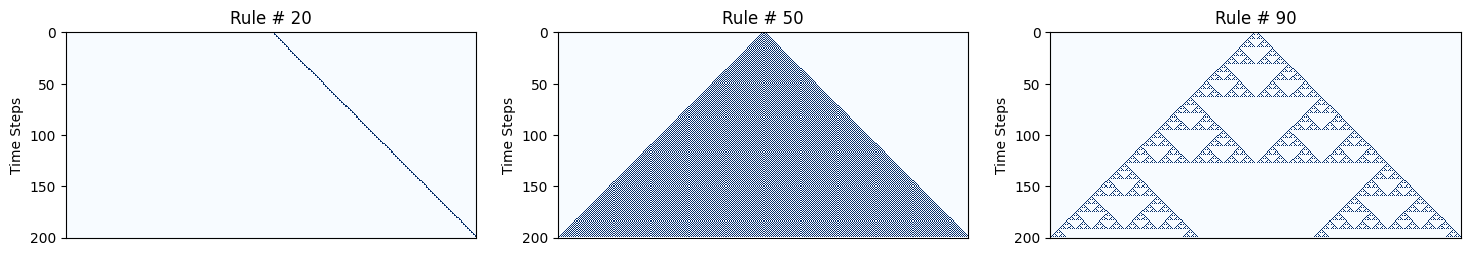

In [25]:
CAs = (20, 50, 90)
plt.subplots(1, 3, figsize=(18, 6))

for plot, rule in enumerate(CAs):
    plt.subplot(1, 3, plot+1)
    experiment(rule)

#### How do cell counts scale?
To measure the scaling behaviour of each CA, we count the number of "live" cells after each timestep.
Simple CA's like rule 20 will scale linearly (1D), CA's that grow to fill the plane like Rule 50 will scale exponentially (2D), others will lie in between.

In [26]:
def count_cells(rule, n_steps=200):
    """ Return a list of "live" cell counts in CA as it scales from 1 to n steps """
    ca = simulate_ca(rule, n_steps)
    return [np.sum(ca[:i]) for i in range(1, n_steps+1) ]

assert count_cells(rule=20, n_steps=5) == [1, 3, 4, 6, 7]
assert count_cells(rule=50, n_steps=5) == [1, 3, 6, 10, 15]

#### Plot the scaling behaviour

**Question**: how does the number of "live" cells scale over time?

**Idea**: plot **cell counts** as a function of the **number of steps**.

The slope of these lines gives an estimate of their dimension in the same way they did for the Koch Curve.
A [linear regression](https://en.wikipedia.org/wiki/Linear_regression) estimates the slope (and other properties) of a line...

In [27]:
def log_slope(xs, ys):
    """ Estimate the slope of log-space plot of data points using linear regression """
    slope,*_ = linregress(np.log(xs), np.log(ys))  # *_?  see https://riptutorial.com/python/example/8400/packing-and-unpacking-tuples
    return slope

def plot_scaling(rule_number, n_steps=200):
    """
    Plot how the given CA rule scales from 1 to n_steps
    Compare this plot to 1D (y = x) and 2D (y = x**2) scaling factors
    """
    cell_counts = count_cells(rule_number, n_steps)
    xs = np.array(range(1,len(cell_counts)+1))

    line_options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(xs, xs**2, label='2-D', **line_options)              # y =  x**2
    plt.plot(xs, cell_counts, '.', label=f'rule={rule_number}')   # y = cell_count at time x
    plt.plot(xs, xs, label='1-D', **line_options)                 # y = x

    title = f'Rule #{rule_number}     Fractal Dimension: {log_slope(xs, cell_counts):0.2f}'
    plt.gca().set(title=title, xlabel='Time Stemps', ylabel='# Live Cells', xscale='log', yscale='log')
    plt.legend()

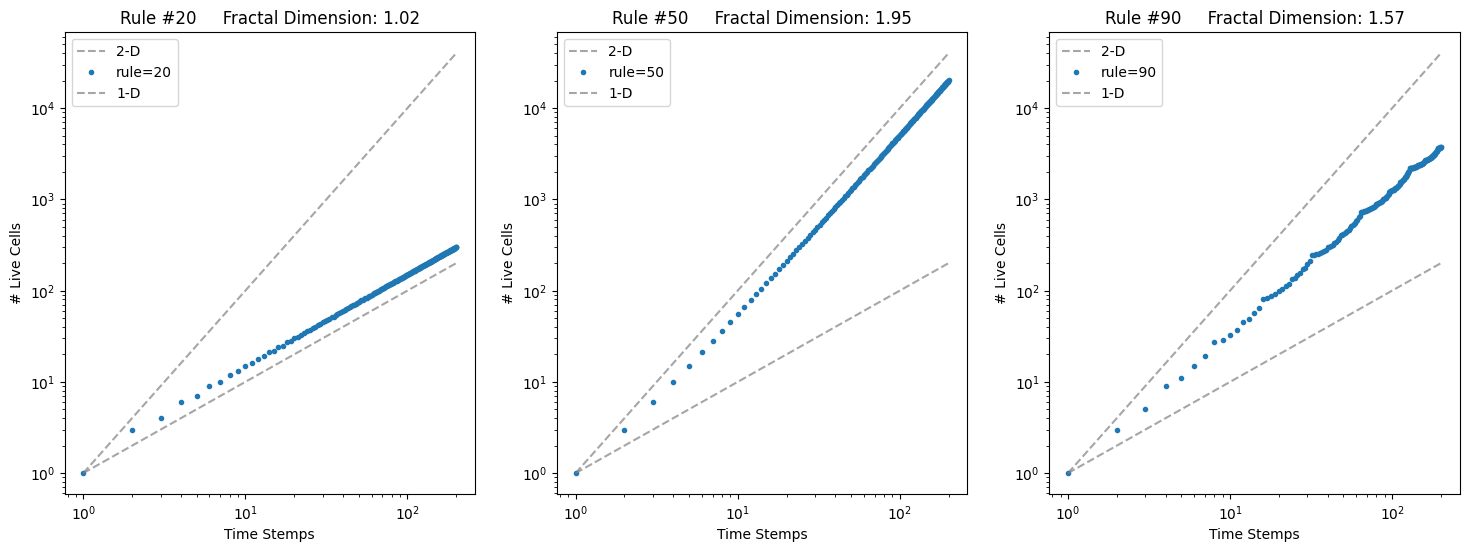

In [28]:
plt.subplots(1, 3, figsize=(18, 6))

for plot, rule in enumerate(CAs):
    ax = plt.subplot(1, 3, plot+1)
    plot_scaling(rule)